## HW4 (a) Overview (30 points + bonus)

This assignment explores the phonetic and acoustic information is captured at different layers of the Hubert model through **probing experiments**. We'll train simple classifiers and regressors to predict various targets from Hubert features:

1. **Phoneme Recognition**: Train a classifier to predict phone labels from Hubert features
2. **MFCC Regression**: Train a regressor to predict MFCC features from Hubert features  
3. **Speaker Embedding**: Analyze speaker separation in Hubert features using t-SNE
4. **Bonus question** - Create your own speaker embedding

Note - You should use a GPU for this part as well.

## What is Probing?

**Probing** is an interpretability technique to understand what information is encoded in different layers of a neural network. We train simple models (probes) to predict specific targets from the network's internal representations. If a probe can successfully predict a target, it suggests that information is encoded in those representations. Note that when training probes, the aim is to not maximize on accuracy but reflect the true information content in features, and hence you should not overparameterize your classifier.

**Key Questions**:
- What phonetic information is captured at each layer?
- How does the model's understanding evolve from acoustic to phonetics through the layers?
- Can we identify speaker-specific patterns in the features?

## Submission

1. Please submit a PDF of the completed notebook with all outputs.
2. Additionally, submit  a PDF REPORT with the plots and deliverables (including answers to the questions).

NOTE - Only the pdf report will be graded, although we may look at the notebook to verify solutions.

### Task 1: Phoneme Recognition (Classification) [10 Points]

**Objective**: Train a classifier to predict phone labels from Hubert features. This tests how well each layer captures **phonetic information**.

**Task Overview**: In this task, you will implement a phoneme recognition probe to understand how phonetic information is encoded across different layers of the Hubert model. You'll load pre-computed Hubert features and corresponding phone labels for each layer (0-12), then train a simple 2-layer neural network classifier to predict phone categories from these features. Your goal is to investigate whether different layers of the model contain varying amounts of phonetic information, and if so, how this information is distributed across the model's depth.

In [1]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, r2_score
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from tqmd import tqmd, trange

In [2]:
torch.cuda.empty_cache()

In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data_zip = '/content/drive/MyDrive/cs283/phoneme_layer_datasets.zip'
print(data_zip)

import zipfile

with zipfile.ZipFile(data_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/cs283/')

/content/drive/MyDrive/cs283/phoneme_layer_datasets.zip


**Download phoneme recognition data using the link below**
https://drive.google.com/file/d/1UuABo6aDByR61DPcESzc6jm5aMAAOM2Y/view?usp=sharing

**Setting up data and Mounting Drive**
To avoid loosing your data as collab runtime disconnects, you should mount your google drive here so that you are able to use the same data folder. An example of how to mount drive is given in the hw4 part b notebook.


In [4]:
def load_phoneme_data(base_folder, layer_idx):
    """
    Helper function to load phoneme data for a specific layer.
    This function loads the features and labels for a specific layer from the base folder.
    The features are loaded as PyTorch tensors and the labels are loaded as JSON files.
    The labels are already string phone names.
    Use this function to load the data for a specific layer.
    We recommend you to play around with the loaded data to understand the format and the information contained.
    """
    base_path = os.path.join(base_folder, f"layer_{layer_idx}")

    # Load features (PyTorch tensors)
    train_features = torch.load(os.path.join(base_path, 'train_features.pt'))
    dev_features = torch.load(os.path.join(base_path, 'dev_features.pt'))
    test_features = torch.load(os.path.join(base_path, 'test_features.pt'))

    # Load labels (JSON files with 'labels' key)
    with open(os.path.join(base_path, 'train_labels.json'), 'r') as f:
        train_labels_data = json.load(f)
    with open(os.path.join(base_path, 'dev_labels.json'), 'r') as f:
        dev_labels_data = json.load(f)
    with open(os.path.join(base_path, 'test_labels.json'), 'r') as f:
        test_labels_data = json.load(f)

    # Extract labels from JSON structure (labels are already string phone names)
    train_labels = train_labels_data['labels']
    dev_labels = dev_labels_data['labels']
    test_labels = test_labels_data['labels']

    # Create vocabulary from all unique labels in the dataset
    all_labels = train_labels + dev_labels + test_labels
    unique_labels = sorted(list(set(all_labels)))
    phone_vocab = {label: idx for idx, label in enumerate(unique_labels)}

    print(f"Created vocabulary with {len(unique_labels)} unique phone classes:")
    print(f"Sample phones: {unique_labels[:10]}")

    # Convert string phone labels to integer indices using our vocabulary
    train_labels = [phone_vocab[label] for label in train_labels]
    dev_labels = [phone_vocab[label] for label in dev_labels]
    test_labels = [phone_vocab[label] for label in test_labels]

    # Convert to PyTorch tensors
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    dev_labels = torch.tensor(dev_labels, dtype=torch.long)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    return train_features, train_labels, dev_features, dev_labels, test_features, test_labels

# Test loading data for layer 0
base_folder = "/content/drive/MyDrive/cs283/phoneme_layer_datasets" #TODO : Change this to the correct base folder.
layer_idx = 0
train_features, train_labels, dev_features, dev_labels, test_features, test_labels = load_phoneme_data(base_folder, layer_idx)

print(f"Layer {layer_idx} data loaded successfully!")
print(f"Train features shape: {train_features.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Dev features shape: {dev_features.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"Number of unique phoneme classes: {len(torch.unique(train_labels))}")
# print(f"Train mean: ", train_features.mean(dim=0, keepdim=True).shape)
print("Train label range:", train_labels.min().item(), train_labels.max().item())
print("Dev label range:", dev_labels.min().item(), dev_labels.max().item())
print("Test label range:", test_labels.min().item(), test_labels.max().item())
# print("num_classes =", num_classes)

"""
Recommended : Play around with the loaded data to understand the information contained in it.
TODO : Figure out the feature dimensionality based on the loaded data. From that, try to figure out which version of Hubert is being used.
"""


Created vocabulary with 72 unique phone classes:
Sample phones: ['AA0', 'AA1', 'AA2', 'AE0', 'AE1', 'AE2', 'AH0', 'AH1', 'AH2', 'AO0']
Layer 0 data loaded successfully!
Train features shape: torch.Size([349544, 768])
Train labels shape: torch.Size([349544])
Dev features shape: torch.Size([34171, 768])
Test features shape: torch.Size([34374, 768])
Number of unique phoneme classes: 72
Train label range: 0 71
Dev label range: 0 71
Test label range: 0 71


'\nRecommended : Play around with the loaded data to understand the information contained in it.\nTODO : Figure out the feature dimensionality based on the loaded data. From that, try to figure out which version of Hubert is being used.\n'

In [5]:
class Probe(nn.Module):
    """Generic 2-layer probe for both classification and regression tasks.
    Make sure to use the same architecture for both classification and regression tasks.
    The architecture should have 2 layers, with intermediate hidden dimension of 128.
    The output layer should have the same dimension as the number of classes in the dataset.
    In between the two layers, use a ReLU activation function.

    Note : Follow the above architecture detail exactly. Do not try to overparameterize the probe.
            You are not graded on the accuracy of the probe but on the interpretability of the results.
    """

    def __init__(self, input_dim=768, hidden_dim=128, output_dim=50,):
        super(Probe, self).__init__()

        # Same 2-layer architecture for both classification and regression
        #self.network = TODO
        self.network = nn.Sequential(
          nn.Linear(input_dim, hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim, output_dim)
        )


    def forward(self, x):
        return self.network(x)

In [6]:
def train_phoneme_probe(base_folder, layer_idx, num_epochs=10, batch_size=512, learning_rate=0.001):
    """Train phoneme probe for a specific layer."""
    print(f"\n{'='*60}")
    print(f"Training Phoneme Probe for Layer {layer_idx}")
    print(f"{'='*60}")

    # Load data
    train_features, train_labels, dev_features, dev_labels, test_features, test_labels = load_phoneme_data(base_folder, layer_idx)

    # Get number of classes
    num_classes = len(torch.unique(train_labels))
    print(f"Number of phone classes: {num_classes}")
    print(f"Training samples: {len(train_features)}")
    print(f"Dev samples: {len(dev_features)}")
    print(f"Test samples: {len(test_features)}")

    # Standardize features
    # TODO : Standardize the features using the mean and standard deviation of the training features.
    train_mean = train_features.mean(dim=0, keepdim=True)
    train_std = train_features.std(dim=0, keepdim=True)

    train_features = (train_features - train_mean) / train_std
    dev_features = (dev_features - train_mean) / train_std
    test_features = (test_features - train_mean) / train_std

    # Move to device
    # TODO : Move the features and labels to the device.
    print("train_features", train_features.shape)
    train_features = train_features.to(device)
    train_labels = train_labels.to(device)
    dev_features = dev_features.to(device)
    dev_labels = dev_labels.to(device)
    test_features = test_features.to(device)
    test_labels = test_labels.to(device)

    # Create model
    # TODO : Create the model using the Probe class. Use cross entropy loss and Adam optimizer.
    model = Probe(input_dim=train_features.shape[1], output_dim=num_classes)
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Create data loaders
    # TODO : Create the data loaders using the TensorDataset and DataLoader classes.
    train_loader = DataLoader(
      TensorDataset(train_features, train_labels),
      batch_size=batch_size,
      shuffle=True
    )

    dev_loader = DataLoader(
      TensorDataset(dev_features, dev_labels),
      batch_size=batch_size,
      shuffle=False
    )

    test_loader = DataLoader(
      TensorDataset(test_features, test_labels),
      batch_size=batch_size,
      shuffle=False
    )

    # Training loop
    # TODO : Implement the training loop.
    for iter in range(num_epochs):
      model.train()
      total_loss = 0
      for features, labels in train_loader:
        optimizer.zero_grad()
        preds = model(features)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
      avg_loss = total_loss / len(train_loader)

    # Test evaluation
    # TODO : Implement the test evaluation.
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
      for features, labels in test_loader:
        preds = model(features)
        predictions = torch.argmax(preds, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.numel()
    test_acc = correct / total

    # Return the results.
    # TODO : Be sure to return the test accuracy for each layer. You should plot the test accuracy for each layer.
    print(f"\nTest Accuracy for Layer {layer_idx}: {test_acc:.4f}")
    return {"layer": layer_idx, "test_acc": test_acc}


In [7]:
### Task 1 : Training the probes
## This code represents an example how the probes are trained.
## You can use this as a reference to train your probes, plot the results.
## You don't have to follow this exact code. Please feel free to modify as per your implementation of the train_phoneme_probe function.


# Train phoneme probes for all layers
base_folder = "/content/drive/MyDrive/cs283/phoneme_layer_datasets"
num_epochs = 5
batch_size = 512

# Store results for all layers
all_results = []

print("Training phoneme probes for all layers (0-12)...")
print("=" * 60)

for layer_idx in range(13):
    print(f"\nTraining Layer {layer_idx}...")
    result = train_phoneme_probe(base_folder, layer_idx, num_epochs, batch_size)
    all_results.append(result)

print(f"\n{'='*60}")
print("TRAINING COMPLETED FOR ALL LAYERS")
print(f"{'='*60}")

# Print test accuracy for each layer
print("\nTest Accuracy by Layer:")
print("-" * 30)
for result in all_results:
    layer = result['layer']
    test_acc = result['test_acc']
    print(f"Layer {layer:2d}: {test_acc:.4f}")

print(f"\nBest performing layer: {max(all_results, key=lambda x: x['test_acc'])['layer']}")
print(f"Best test accuracy: {max(all_results, key=lambda x: x['test_acc'])['test_acc']:.4f}")


Training phoneme probes for all layers (0-12)...

Training Layer 0...

Training Phoneme Probe for Layer 0
Created vocabulary with 72 unique phone classes:
Sample phones: ['AA0', 'AA1', 'AA2', 'AE0', 'AE1', 'AE2', 'AH0', 'AH1', 'AH2', 'AO0']
Number of phone classes: 72
Training samples: 349544
Dev samples: 34171
Test samples: 34374
train_features torch.Size([349544, 768])

Test Accuracy for Layer 0: 0.6368

Training Layer 1...

Training Phoneme Probe for Layer 1
Created vocabulary with 72 unique phone classes:
Sample phones: ['AA0', 'AA1', 'AA2', 'AE0', 'AE1', 'AE2', 'AH0', 'AH1', 'AH2', 'AO0']
Number of phone classes: 72
Training samples: 349533
Dev samples: 34187
Test samples: 34206
train_features torch.Size([349533, 768])

Test Accuracy for Layer 1: 0.6714

Training Layer 2...

Training Phoneme Probe for Layer 2
Created vocabulary with 72 unique phone classes:
Sample phones: ['AA0', 'AA1', 'AA2', 'AE0', 'AE1', 'AE2', 'AH0', 'AH1', 'AH2', 'AO0']
Number of phone classes: 72
Training sa

### Task 1: Deliverables

1. Plot of phoneme recognition accuracy on y-axis vs layers (5 points)

2. Answer the following questions:
    
    2.1 The features used in this task belongs to which version of the Hubert model ? (1 point)

    2.2 What layer features does best in the phoneme recognition task? (1 point)

    2.3 What does this plot show about how phonetic information is captured by Hubert? Why do you think that's the case? (3 points)


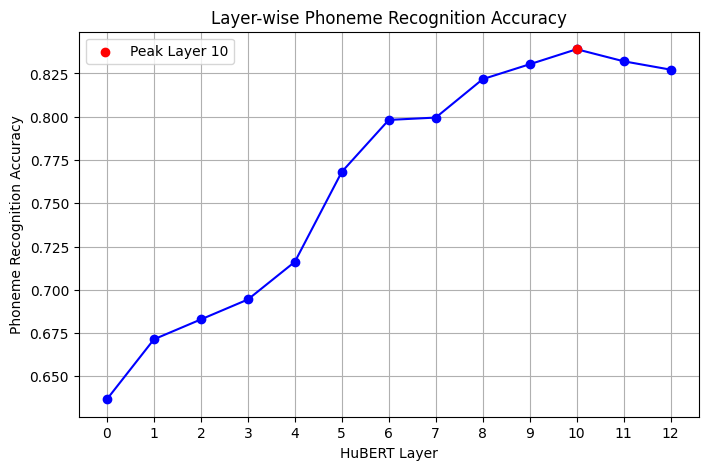

In [10]:
# plot all_results
import matplotlib.pyplot as plt

# Extract layers and accuracies
layers = [r['layer'] for r in all_results]
test_accs = [r['test_acc'] for r in all_results]

# Create the plot
plt.figure(figsize=(8,5))
plt.plot(layers, test_accs, marker='o', linestyle='-', color='blue')
plt.xticks(layers)
plt.xlabel("HuBERT Layer")
plt.ylabel("Phoneme Recognition Accuracy")
plt.title("Layer-wise Phoneme Recognition Accuracy")
plt.grid(True)

# Highlight peak
max_idx = test_accs.index(max(test_accs))
plt.scatter(layers[max_idx], test_accs[max_idx], color='red', zorder=5, label=f"Peak Layer {layers[max_idx]}")
plt.legend()
plt.savefig("/content/drive/MyDrive/cs283/phoneme_accuracy_by_layer.png", dpi=300, bbox_inches='tight')

plt.show()

Answer the following questions:

2.1 The features used in this task belongs to which version of the Hubert model ? (1 point)

- We are using Hubert base here.


2.2 What layer features does best in the phoneme recognition task? (1 point)

- Layer 10 performs the best in the phoneme recognition task, with an accuracy of 83.90%.

2.3 What does this plot show about how phonetic information is captured by Hubert? Why do you think that's the case? (3 points)

- Accuracy increases from layer 0 to layer 10.
- Early layers capture low-level acoustic information (spectral features, formants).
- Accuracy peaks at layer 10, then slightly declines at layers 11 and 12.
- Later layers encode more contextual or semantic information, focusing on the masked prediction task rather than raw phonetic identity.
- Middle-to-late layers contain the most explicit phonetic information, because the model balances between representing local acoustic patterns and higher-level context.
- Final layers specialize for the model's training objective (masked unit prediction), which dilutes phonetic information.


### Task 2: MFCC Regression [10 points]

**Objective**: Train a regressor to predict MFCC features from Hubert features. This tests how well each layer captures **acoustic information**.

**What are MFCC Features?**

**MFCC (Mel-Frequency Cepstral Coefficients)** are acoustic features that capture the spectral characteristics of speech. MFCCs are computed by:
1. **Windowing** the audio signal into short frames (typically 25ms)
2. **Computing FFT** to get frequency spectrum
3. **Mel-scale filtering** to simulate human auditory perception
4. **Log transformation** to compress dynamic range
5. **DCT (Discrete Cosine Transform)** to decorrelate coefficients

The 13 MFCC coefficients capture different aspects of the acoustic signal, with lower coefficients representing broader spectral characteristics and higher coefficients capturing finer details.

**Task Overview**: In this task, you will implement an **MFCC regression probe** to understand how acoustic information is encoded across different layers of the Hubert model. You'll load pre-computed Hubert features and corresponding MFCC labels for each layer (0-12), then train a regression probe using the previously defined probe to predict 13 MFCC coefficients from these features. Your goal is to investigate whether different layers of the model contain varying amounts of acoustic information, and if so, how this information is distributed across the model's depth. You'll train separate regressors for each of the 13 layers, evaluate them on held-out test sets using R² scores, and analyze the results to understand what Hubert has learned about acoustic properties at each stage of processing.

**Download mfcc dataset using this link**
https://drive.google.com/file/d/12ikp8GxiU7Ul3i5fR-9Sz2YMt9Jdshv4/view?usp=sharing

In [12]:
data_zip = '/content/drive/MyDrive/cs283/mfcc_layer_datasets.zip'
print(data_zip)

import zipfile

with zipfile.ZipFile(data_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/cs283/')

/content/drive/MyDrive/cs283/mfcc_layer_datasets.zip


In [15]:
def load_mfcc_data(base_folder, layer_idx):
    """Load MFCC data for a specific layer."""
    base_path = os.path.join(base_folder, f"layer_{layer_idx}")

    # Load features (PyTorch tensors)
    train_features = torch.load(os.path.join(base_path, 'train_features.pt'))
    dev_features = torch.load(os.path.join(base_path, 'dev_features.pt'))
    test_features = torch.load(os.path.join(base_path, 'test_features.pt'))

    # Load MFCC labels (JSON files with 'mfcc' key)
    with open(os.path.join(base_path, 'train_mfcc_labels.json'), 'r') as f:
        train_labels_data = json.load(f)
    with open(os.path.join(base_path, 'dev_mfcc_labels.json'), 'r') as f:
        dev_labels_data = json.load(f)
    with open(os.path.join(base_path, 'test_mfcc_labels.json'), 'r') as f:
        test_labels_data = json.load(f)

    # Extract MFCC labels from JSON structure (labels are 13-element lists)
    train_mfcc_labels = train_labels_data['mfcc']  # List of 13-element lists
    dev_mfcc_labels = dev_labels_data['mfcc']
    test_mfcc_labels = test_labels_data['mfcc']

    # Convert to PyTorch tensors (shape: [n_frames, 13])
    train_labels = torch.tensor(train_mfcc_labels, dtype=torch.float32)
    dev_labels = torch.tensor(dev_mfcc_labels, dtype=torch.float32)
    test_labels = torch.tensor(test_mfcc_labels, dtype=torch.float32)

    return train_features, train_labels, dev_features, dev_labels, test_features, test_labels

# Test loading MFCC data for layer 0
base_folder = "/content/drive/MyDrive/cs283/mfcc_layer_datasets"
layer_idx = 0
train_features, train_labels, dev_features, dev_labels, test_features, test_labels = load_mfcc_data(base_folder, layer_idx)

print(f"MFCC data loaded for layer {layer_idx}:")
print(f"Train features shape: {train_features.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Dev features shape: {dev_features.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"MFCC coefficients: {train_labels.shape[1]}")
print(f"Number of unique phoneme classes: {len(torch.unique(train_labels))}")
print(train_labels[:, 0])



MFCC data loaded for layer 0:
Train features shape: torch.Size([349544, 768])
Train labels shape: torch.Size([349544, 13])
Dev features shape: torch.Size([34171, 768])
Test features shape: torch.Size([34374, 768])
MFCC coefficients: 13
Number of unique phoneme classes: 4420227
tensor([-538.4293, -604.7202, -439.6280,  ..., -691.5099, -395.4695,
        -493.8039])


In [20]:
# print(train_features[1, :])

tensor([-2.5614e-01,  9.3969e-03, -8.8495e-02,  1.3491e-01,  4.1419e-01,
         9.2820e-02, -5.0132e-02,  9.4593e-02, -1.6151e-01, -1.3898e-01,
        -1.0322e-01,  1.1413e-01, -3.3999e-01,  3.8063e-01,  3.2785e-01,
         1.0282e-01, -1.5646e-01, -5.2258e-02, -1.0449e-01, -2.4279e-01,
         9.3766e-02, -2.5879e-01, -7.1667e-02, -4.0018e-01,  1.6836e-01,
         2.2565e-01,  1.6721e-02,  8.4799e-02, -4.7301e-02, -3.5313e-01,
        -2.2932e-01, -4.3820e-03,  1.2045e-01, -8.4668e-02, -1.6703e-01,
        -1.7346e-02, -2.4525e-01, -2.5429e-01,  2.6471e-02, -3.3620e-01,
         4.0778e-02,  2.6945e-01, -1.8627e-01, -2.1539e-01, -1.5691e-01,
        -2.0089e-01, -9.9544e-02,  1.1790e-01,  4.2404e-01, -6.7091e-02,
         6.9400e-02,  4.5664e-01, -1.9802e-01,  4.9891e-01, -1.1966e-01,
         5.9023e-02,  6.1099e-01, -7.1695e-02,  1.8042e-02, -2.9140e-01,
        -1.5725e-01,  1.9611e-01, -1.8292e-01, -1.5797e-01,  7.9098e-02,
         7.5022e-02, -4.4279e-02, -1.1573e-01, -6.0

In [ ]:
# Corrected MFCC training function
def train_mfcc_probe(base_folder, layer_idx, num_epochs=10, batch_size=512, learning_rate=0.001):
    """Train MFCC probe for a specific layer."""
    print(f"\n{'='*60}")
    print(f"Training MFCC Probe for Layer {layer_idx}")
    print(f"{'='*60}")

    # Load data using the correct function signature
    train_features, train_labels, dev_features, dev_labels, test_features, test_labels = load_mfcc_data(base_folder, layer_idx)

    print(f"Training samples: {len(train_features)}")
    print(f"Dev samples: {len(dev_features)}")
    print(f"Test samples: {len(test_features)}")
    print(f"MFCC dimensions: {train_labels.shape[1]}")

    # Standardize features
    # TODO : Standardize the features using the mean and standard deviation of the training features.
    train_mean = train_features.mean(dim=0, keepdim=True)
    train_std = train_features.std(dim=0, keepdim=True)

    train_features = (train_features - train_mean) / train_std
    dev_features = (dev_features - train_mean) / train_std
    test_features = (test_features - train_mean) / train_std

    # Move to device
    # TODO : Move the features and labels to the device.
    train_features = train_features.to(device)
    train_labels = train_labels.to(device)
    dev_features = dev_features.to(device)
    dev_labels = dev_labels.to(device)
    test_features = test_features.to(device)
    test_labels = test_labels.to(device)


    # Create model using unified Probe class
    # TODO : Create the model using the exact same Probe class as before. Use MSE loss and Adam optimizer.
    num_classes = len(torch.unique(train_labels))
    model = Probe(input_dim=train_features.shape[1], output_dim=num_classes)
    model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Create data loaders
    # TODO : Create the data loaders using the TensorDataset and DataLoader classes.
    train_loader = DataLoader(
      TensorDataset(train_features, train_labels),
      batch_size=batch_size,
      shuffle=True
    )

    dev_loader = DataLoader(
      TensorDataset(dev_features, dev_labels),
      batch_size=batch_size,
      shuffle=False
    )

    test_loader = DataLoader(
      TensorDataset(test_features, test_labels),
      batch_size=batch_size,
      shuffle=False
    )

    # Training loop
    # TODO : Implement the training loop.
    for iter in range(num_epochs):
      model.train()
      total_loss = 0
      for features, labels in train_loader:
        optimizer.zero_grad()
        preds = model(features)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
      avg_loss = total_loss / len(train_loader)

    # Test evaluation
    # TODO : Implement the test evaluation. The metric we are looking for is the R^2 metric on the test set.
    model.eval()
    r2_metric = 0
    for features, labels in test_loader:
      optimizer.zero_grad()
      preds = model(features)
      loss = criterion(preds, labels)
      loss.backward()
      optimizer.step()




    # Return the results.
    # TODO : Be sure to return the test R^2 for each layer. You should plot the test R^2 for each layer.



In [ ]:
### Task 2 : Example code for training MFCC probes
## This code represents an example how the probes are trained.
## You can use this as a reference to train your probes, plot the results.
## You don't have to follow this exact code. Please feel free to modify as per your prior implementations.


# Train MFCC probes for all layers
base_folder = "mfcc_layer_datasets"
num_epochs = 5
batch_size = 512

# Store results for all layers
mfcc_all_results = []

print("Training MFCC probes for all layers (0-12)...")
print("=" * 60)

for layer_idx in range(13):
    print(f"\nTraining Layer {layer_idx}...")
    result = train_mfcc_probe(base_folder, layer_idx, num_epochs, batch_size)
    mfcc_all_results.append(result)

print(f"\n{'='*60}")
print("TRAINING COMPLETED FOR ALL LAYERS")
print(f"{'='*60}")

# Print test R² for each layer
print("\nTest R² by Layer:")
print("-" * 30)
for result in mfcc_all_results:
    layer = result['layer']
    test_r2 = result['overall_r2']
    print(f"Layer {layer:2d}: {test_r2:.4f}")

print(f"\nBest performing layer: {max(mfcc_all_results, key=lambda x: x['overall_r2'])['layer']}")
print(f"Best test R²: {max(mfcc_all_results, key=lambda x: x['overall_r2'])['overall_r2']:.4f}")

### Task 2: Deliverables

1. Plot of MFCC regression R^2 metric on y-axis vs layers (5 points)

2. Answer the following questions:

    2.1 What layer features does best MFCC regression task? (1 point)

    2.2 What does layer 0 represent in the Hubert model? (1 point)

    2.3 What does this plot show about how acoustic information is captured by Hubert? Why do you think that's the case? (3 points)


### Task 3: Speaker Embedding Analysis [10 points]

**Objective**: Analyze how well Hubert features capture **speaker identity** using t-SNE visualization.

Speaker embedding analysis investigates how well neural network representations capture speaker-specific information. Unlike phonetic or acoustic features that focus on linguistic content, speaker embeddings capture the unique characteristics that distinguish one speaker from another, such as:

- **Voice characteristics**: Fundamental frequency (F0), vocal tract length, speaking rate
- **Speaking style**: Prosody, rhythm, intonation patterns  
- **Physiological features**: Age, gender, accent, regional variations
- **Behavioral patterns**: Individual speaking habits and preferences

**Task Overview**: In this task, you will implement a **speaker embedding analysis** to understand how speaker identity information is encoded across different layers of the Hubert model. You will extract audio features from 20 speakers and compute mean-pooled Hubert features from for each layer, and use t-SNE dimensionality reduction to visualize how well different layers separate speakers in the feature space. Your goal is to investigate whether different layers of the model contain varying amounts of speaker information, and if so, how this information is distributed across the model's depth. You'll analyze t-SNE plots for all 13 layers to understand how Hubert's internal representations evolve from speaker-agnostic to speaker-specific information. This experiment will help you understand how Hubert balances linguistic content with speaker identity across its layers.


**download speaker embedding data from here**
https://drive.google.com/file/d/1L7r1c6_CIPVxNIQVPfrhD_Wt1MKCypU1/view?usp=sharing

In [ ]:
# Import additional libraries for speaker embedding analysis
from transformers import HubertModel, Wav2Vec2FeatureExtractor
import torchaudio
from sklearn.manifold import TSNE
import seaborn as sns

In [ ]:

def load_hubert_model():
    """
    Load the Hubert model and feature extractor.
    """
    print("Loading Hubert model...")
    model = HubertModel.from_pretrained("facebook/hubert-base-ls960")
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
    return model, feature_extractor

def extract_speaker_embedding(audio_path, model, feature_extractor, layer_idx=0):
    """
    Extract Hubert features from a specific layer.

    Args:
        audio_path (str): Path to audio file
        model: Hubert model
        feature_extractor: Hubert feature extractor
        layer_idx (int): Layer index (0-12, where 0 is embedding layer)

    Returns:
        torch.Tensor: Features from the specified layer
    """
    # Load and preprocess audio using torchaudio
    audio, sr = torchaudio.load(audio_path)

    # Resample to 16kHz if needed. Hubert model expects 16kHz audio.

    # Extract features from the specified layer.

    # TODO : Make sure to do mean-pooling across the time dimension.
    ## The speaker embedding from each layer is the mean-pooled features across the time dimension.

    # Return the mean-pooled features.


In [ ]:
# TODO : Go through the dataset and extract the speaker embeddings for each layer.
# Audio files are present as 307-127535-0000.flac. The speaker id is 307. All audio files with the same speaker id are from the same speaker.
# Each speaker should have 50 audios per speaker. You will thus extract 50 embeddings per speaker for each layer. Do this for all 20 speakers.

# TODO : Use t-SNE to visualize the speaker embeddings. We want to see clusters of the embeddings by speaker id.

# TODO : Plot the t-SNE plot for all 13 layers separately.

### Task 3: Deliverables

1. Plot the speaker embedding t-SNE plots for each layer. There should be 13 plots. Each plot should have 20 clusters, 1 per speaker, with 50 speaker embeddings per speaker. (5 points)

2. Answer the following questions:

    2.1 Do speaker embeddings form neat clusters or mix together? (1 point)

    2.2 What does this plot show about how speaker information is captured by Hubert? Answer this question based on how the plots evolve as we go deeper into the model. (4 points)


### Bonus: Make your own Speaker Embedding Cluster (10 points)

1. Record 5 **different** sentences in your own voice in each of the following settings:

   1.1 Use two different mics (For example laptop and phone or something else)

   1.2 For each mic, record yourself in 3 different enviornments (eg: home, campus, bus, or whever else you are comfortable using your mics). Make sure to use the same 3 environments with both mics.
   
   1.3 You should have 2 * 3 * 5 = 30 recordings, divided into 6 groups of 5 recordings.
2. Create speaker embeddings for audio files using the mean pooling code for each group.
3. Create your own speaker embedding cluster and add it to one of the plots above with the other speakers in the dataset. You can choose the layer of your choice. Note that you should add 6 additional groups in the existing clusters. This graph is the final deliverable (6 points).

Answer the following questions:
1. What do you observe about how the 6 groups are placed with respect to the clusters of the other speakers? Explain why. (2 points)
2. What do you observe about how the 6 groups are arranged amongst each other? Explain why. (2 points)